C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14292\1531055749.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hour'] = data.index.hour


[0]	validation_0-rmse:14.69980	validation_1-rmse:14.49009
[100]	validation_0-rmse:5.12148	validation_1-rmse:4.76860
[200]	validation_0-rmse:4.25723	validation_1-rmse:3.95879
[300]	validation_0-rmse:4.10018	validation_1-rmse:3.88759
[362]	validation_0-rmse:4.04421	validation_1-rmse:3.89507
RMSE Score on Test set for Temp: 3.89


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14292\1531055749.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


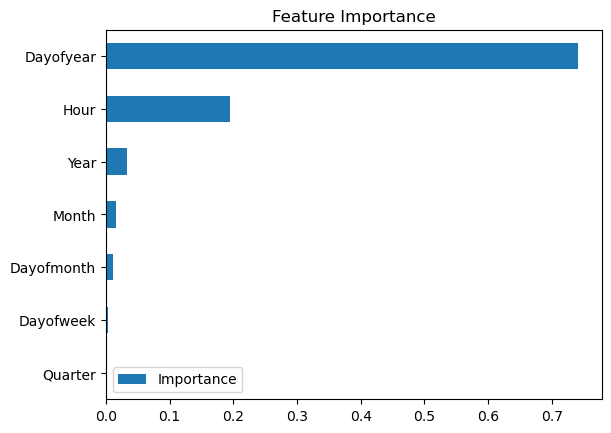

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14292\1531055749.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hour'] = data.index.hour


[0]	validation_0-rmse:0.29904	validation_1-rmse:0.30683
[100]	validation_0-rmse:0.14574	validation_1-rmse:0.14064
[200]	validation_0-rmse:0.13166	validation_1-rmse:0.13050
[246]	validation_0-rmse:0.12883	validation_1-rmse:0.13136
RMSE Score on Test set for RH: 0.13


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14292\1531055749.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


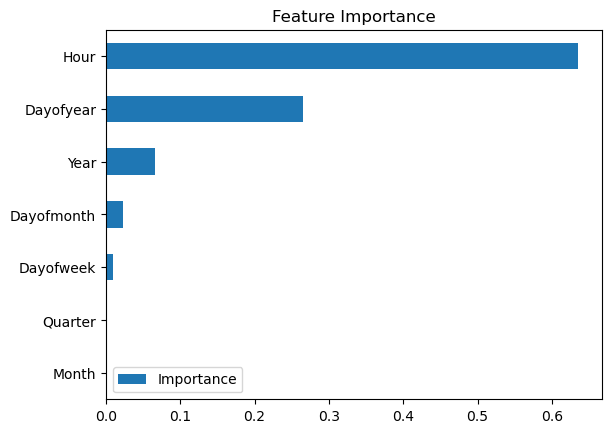

[0]	validation_0-rmse:995.32547	validation_1-rmse:995.37085
[100]	validation_0-rmse:132.07931	validation_1-rmse:132.11414
[200]	validation_0-rmse:18.02548	validation_1-rmse:18.01323
[300]	validation_0-rmse:4.79575	validation_1-rmse:4.71552
[400]	validation_0-rmse:4.14404	validation_1-rmse:4.12558
[500]	validation_0-rmse:4.06631	validation_1-rmse:4.09332
[600]	validation_0-rmse:4.00778	validation_1-rmse:4.08940
[619]	validation_0-rmse:3.99878	validation_1-rmse:4.09050
RMSE Score on Test set for Press: 4.09


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14292\1531055749.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


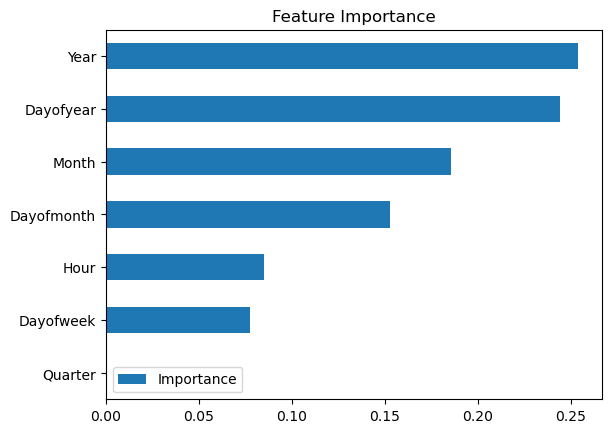

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import joblib

# Read the data
df = pd.read_csv("weatherHistory.csv", na_values=['-999'])

# Select relevant columns and rename them
df = df[['Formatted Date', 'Temperature (C)', 'Humidity', 'Pressure (millibars)']]
df.columns = ['Date & Time', 'Temp', 'RH', 'Press']

# Convert Date & Time column to datetime index
df['Date & Time'] = pd.to_datetime(df['Date & Time'], utc=True)
df.set_index('Date & Time', inplace=True)

# Function for data preprocessing and model training
def train_model(data, target):
    # EDA and feature engineering
    data['Hour'] = data.index.hour
    data['Dayofweek'] = data.index.dayofweek
    data['Month'] = data.index.month
    data['Year'] = data.index.year
    data['Quarter'] = data.index.quarter
    data['Dayofyear'] = data.index.dayofyear
    data['Dayofmonth'] = data.index.day

    # Split the data into train and test sets
    train = data[data.index < '2014-01-01']
    test = data[data.index >= '2014-01-01']

    # Select features and target
    features = ['Hour', 'Dayofweek', 'Month', 'Year', 'Quarter', 'Dayofyear', 'Dayofmonth']
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # Train the XGBoost model
    reg = xgb.XGBRegressor(
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.02
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    # Predict on the test set
    test['prediction'] = reg.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test[target], test['prediction']))
    print(f'RMSE Score on Test set for {target}: {rmse:.2f}')

    # Plot feature importance
    fi = pd.DataFrame(data=reg.feature_importances_, index=features, columns=['Importance'])
    fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')
    plt.show()

    # Save the trained model
    joblib.dump(reg, f'{target.lower()}_model.pkl')

    return test

# Temperature prediction
temp_data = df[['Temp']]
temp_test = train_model(temp_data, 'Temp')

# Humidity prediction
humidity_data = df[['RH']]
humidity_test = train_model(humidity_data, 'RH')

# Pressure prediction
pressure_data = df[['Press']].dropna()
pressure_data = pressure_data.query('Press > 1007 and Press < 1025').copy()
pressure_test = train_model(pressure_data, 'Press')
